In [6]:
from load import load_training_data

file_path = "data"

df = load_training_data("data/20251207-bq-results-with-mid-pkgs.jsonl")

# df = load_training_data("data/bq-results-20251207-053959-1765086112714.json")
df.head()

,pkg_name,n_name_len,has_digit_in_name,has_dash_or_underscore,cat_name_case,n_summary_len,n_desc_len,n_desc_lines,has_code_block_in_desc,n_urls_in_desc,...,n_lev_dist_to_alias,sim_tfidf_to_legit_centroid,dist_embed_to_legit_desc,n_pkgs_by_maintainers_30d,n_low_download_pkgs_by_maintainers,n_latest_project_urls,has_dependency_to_top_brand,min_dep_lev_to_brand,has_dependency_lev_close_to_brand,t_time_of_day
0,tree-sitter-css,15,False,True,lower,27,1086,22,False,14,...,12,0.116914,0.873038,1.0,0.0,2,0,8.0,0,morning
1,requests-mock,13,False,True,lower,44,2858,102,False,13,...,10,0.082427,0.796754,0.0,0.0,1,1,0.0,1,night
2,liblapack-dev,13,False,True,lower,36,0,1,False,0,...,10,0.061897,1.000000,0.0,8.0,0,0,20.0,0,night
3,upgini,6,False,False,lower,57,39820,690,True,79,...,5,0.027167,0.870642,2.0,0.0,3,1,0.0,1,afternoon
4,opencv-python,13,False,True,lower,43,19952,256,True,33,...,11,0.135120,0.826769,0.0,0.0,0,0,20.0,0,morning


In [7]:
print(df.shape)
print(df.columns)
print(df.head(3))

(15587, 52)
Index(['pkg_name', 'n_name_len', 'has_digit_in_name', 'has_dash_or_underscore',
       'cat_name_case', 'n_summary_len', 'n_desc_len', 'n_desc_lines',
       'has_code_block_in_desc', 'n_urls_in_desc', 'has_suspicious_kw',
       'pct_non_ascii_desc', 't_age_first_release_days',
       't_age_last_release_days', 'n_versions', 't_median_release_gap_days',
       'has_single_release', 'cat_weekday_of_last_release', 'n_maintainers',
       'pct_free_email_domains', 'has_disposable_email', 'has_missing_author',
       'has_homepage', 'has_repo_url', 'cat_repo_host', 'has_issue_tracker',
       'has_docs_url', 'has_license', 'cat_license_family', 'n_classifiers',
       'has_prog_lang_classifier', 'has_typing_classifier', 'n_distributions',
       'n_requires', 'has_extras', 'n_downloads_7d', 'n_downloads_30d',
       'n_dependents_est', 'rule_no_repo_low_desc_len',
       'rule_suspicious_name_and_dep', 'is_spam', 'n_lev_dist_to_top1',
       'n_lev_dist_to_alias', 'sim_tfidf_t

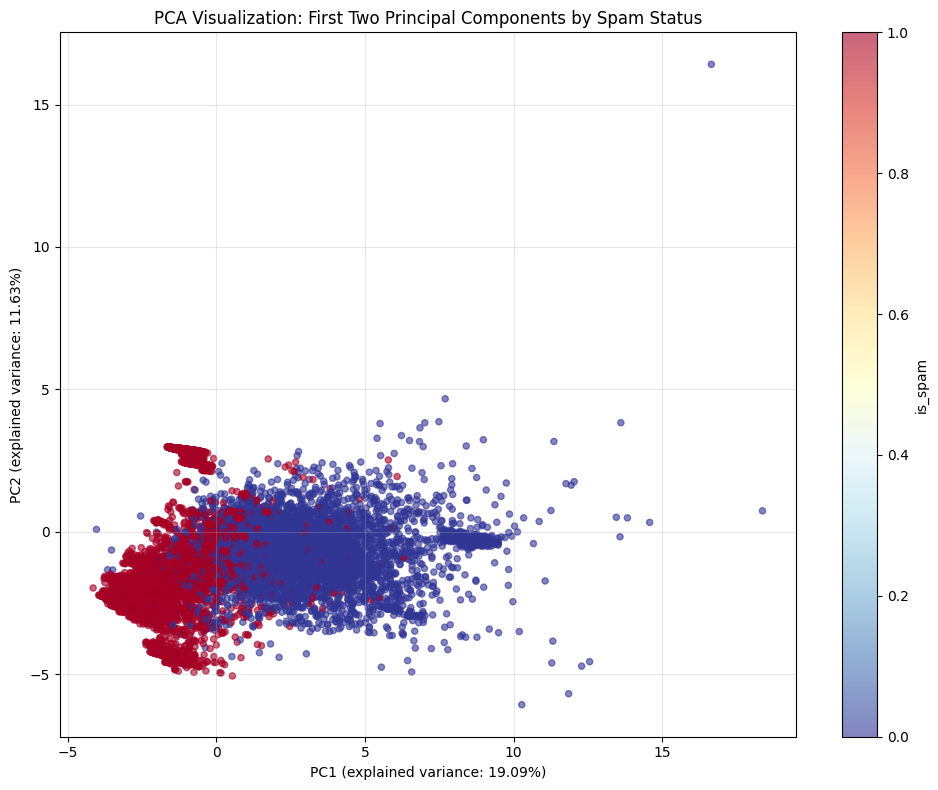

Total explained variance: 30.73%
PC1 explained variance: 19.09%
PC2 explained variance: 11.63%


In [5]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Separate target variable
target = df["is_spam"].copy()

# Select feature columns (exclude pkg_name and is_spam)
feature_cols = [col for col in df.columns if col not in ["pkg_name", "is_spam"]]

# Get feature data
X = df[feature_cols].copy()

# Handle categorical columns - convert to numeric or drop
# For boolean columns, convert to int
bool_cols = X.select_dtypes(include=["bool"]).columns
X[bool_cols] = X[bool_cols].astype(int)

# For categorical string columns, we'll use one-hot encoding or drop them
# Let's identify categorical columns
cat_cols = [
    "cat_name_case",
    "cat_weekday_of_last_release",
    "cat_repo_host",
    "cat_license_family",
    "t_time_of_day",
]
# One-hot encode categorical columns
X_encoded = pd.get_dummies(
    X, columns=[col for col in cat_cols if col in X.columns], drop_first=True
)

# Handle any remaining non-numeric columns
numeric_cols = X_encoded.select_dtypes(include=[np.number]).columns
X_final = X_encoded[numeric_cols]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=target, cmap="RdYlBu_r", alpha=0.6, s=20
)
plt.colorbar(scatter, label="is_spam")
plt.xlabel(f"PC1 (explained variance: {pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 (explained variance: {pca.explained_variance_ratio_[1]:.2%})")
plt.title("PCA Visualization: First Two Principal Components by Spam Status")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")
print(f"PC1 explained variance: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2 explained variance: {pca.explained_variance_ratio_[1]:.2%}")


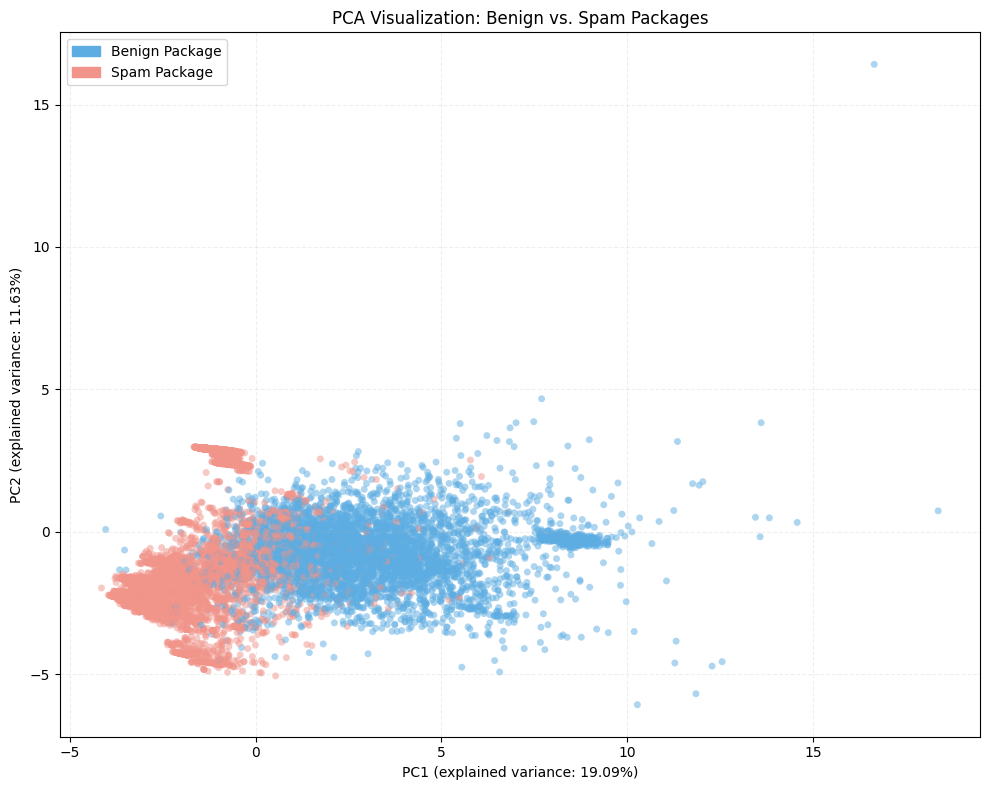

Total explained variance: 100.00%
PC1 explained variance: 19.09%
PC2 explained variance: 11.63%


In [11]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Set random seed for reproducibility
np.random.seed(42)

# Separate target variable
target = df["is_spam"].copy()

# Select feature columns (exclude pkg_name and is_spam)
feature_cols = [col for col in df.columns if col not in ["pkg_name", "is_spam"]]

# Get feature data
X = df[feature_cols].copy()

# Handle categorical columns - convert to numeric or drop
# For boolean columns, convert to int
bool_cols = X.select_dtypes(include=["bool"]).columns
X[bool_cols] = X[bool_cols].astype(int)

# For categorical string columns, we'll use one-hot encoding
cat_cols = [
    "cat_name_case",
    "cat_weekday_of_last_release",
    "cat_repo_host",
    "cat_license_family",
    "t_time_of_day",
]
X_encoded = pd.get_dummies(
    X, columns=[col for col in cat_cols if col in X.columns], drop_first=True
)

# Handle any remaining non-numeric columns
numeric_cols = X_encoded.select_dtypes(include=[np.number]).columns
X_final = X_encoded[numeric_cols]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# Apply PCA
pca = PCA(n_components=X_scaled.shape[1])
X_pca = pca.fit_transform(X_scaled)

# --- VISUALIZATION CHANGES START HERE ---

# 1. Define Lighter, Distinctive Colors
# Soft Blue for Benign (0), Soft Coral/Red for Spam (1)
custom_colors = ["#5DADE2", "#F1948A"]
cmap = ListedColormap(custom_colors)

plt.figure(figsize=(10, 8))

# 2. Scatter Plot with improved alpha and custom cmap
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=target,
    cmap=cmap,
    alpha=0.5,  # Increased transparency (lower value = more transparent)
    s=25,  # Slightly larger dots for visibility
    edgecolor="none",  # Remove dark edges around dots to make them look softer
)

# 3. Create a Manual Legend (Cleaner than a colorbar for binary data)
legend_handles = [
    mpatches.Patch(color=custom_colors[0], label="Benign Package"),
    mpatches.Patch(color=custom_colors[1], label="Spam Package"),
]
plt.legend(handles=legend_handles, loc="best")

plt.xlabel(f"PC1 (explained variance: {pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 (explained variance: {pca.explained_variance_ratio_[1]:.2%})")
plt.title("PCA Visualization: Benign vs. Spam Packages")
plt.grid(True, alpha=0.2, linestyle="--")  # Softer grid lines
plt.tight_layout()
plt.show()

# --- VISUALIZATION CHANGES END HERE ---

print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")
print(f"PC1 explained variance: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2 explained variance: {pca.explained_variance_ratio_[1]:.2%}")


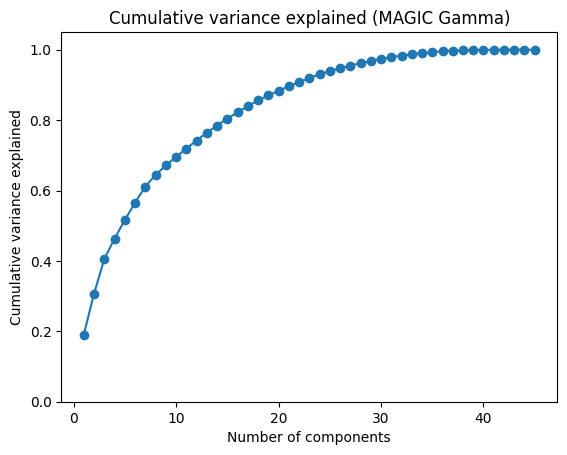

In [12]:
var_ratio = (
    pca.explained_variance_ratio_
)  # variance (ratio) explained by each component
cum_var_ratio = np.cumsum(var_ratio)  # cumulative variance (ratio) explained
n_components = len(var_ratio)  # number of components
# Cumulative variance explained plot

plt.figure()
plt.plot(range(1, n_components + 1), cum_var_ratio, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance explained")
plt.title("Cumulative variance explained (MAGIC Gamma)")
plt.ylim(0, 1.05)
plt.show()

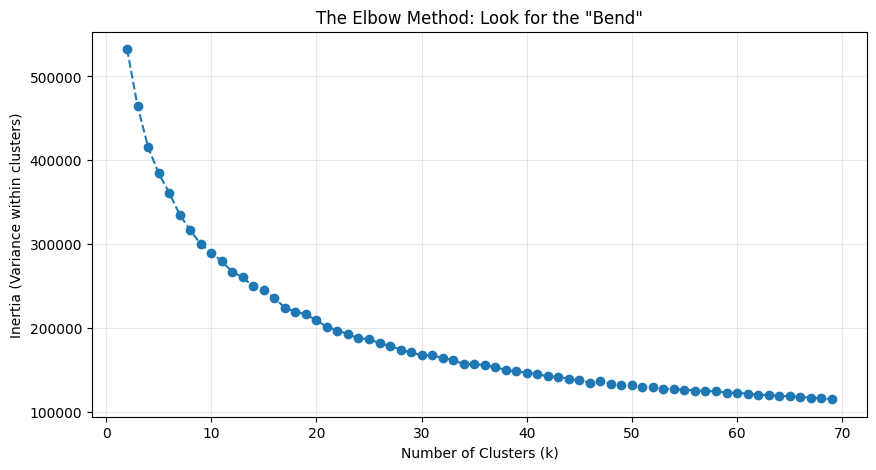

In [16]:
from sklearn.cluster import KMeans
import seaborn as sns

# 1. PREP: Get the 25 Components
# Assuming 'X_scaled' is your standardized original data
pca_25 = PCA(n_components=25, random_state=42)
X_pca_25 = pca_25.fit_transform(X_scaled)

# ---------------------------------------------------------
# STEP 2: THE ELBOW METHOD (Finding the right 'K')
# ---------------------------------------------------------
inertia = []
k_range = range(2, 70)  # Test between 2 and 15 clusters

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(X_pca_25)
    inertia.append(kmeans_test.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, marker="o", linestyle="--")
plt.title('The Elbow Method: Look for the "Bend"')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Variance within clusters)")
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
# ---------------------------------------------------------
# STEP 3: APPLY CLUSTERING (Let's assume K=5 based on the plot)
# ---------------------------------------------------------
optimal_k = 10  # <--- UPDATE THIS based on the plot above!
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca_25)

# Add clusters back to your original dataframe to interpret them
df_analysis = df.copy()
df_analysis["cluster"] = cluster_labels

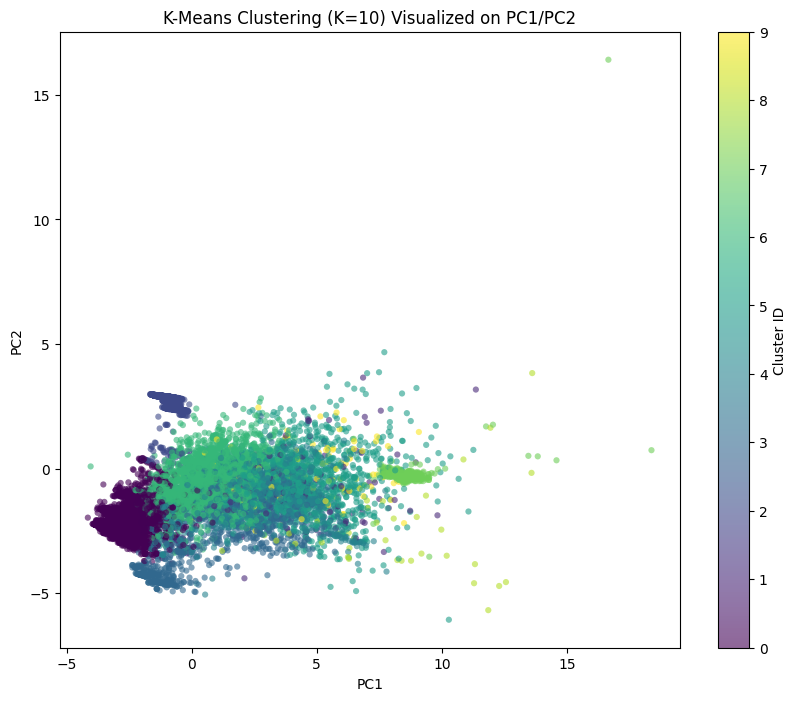

In [18]:
# ---------------------------------------------------------
# STEP 4: VISUALIZE CLUSTERS ON 2D PCA
# ---------------------------------------------------------
# We use the first 2 PCs for visualization, but color by the 25D Clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=cluster_labels,
    cmap="viridis",
    alpha=0.6,
    s=20,
    edgecolor="none",
)
plt.colorbar(scatter, label="Cluster ID")
plt.title(f"K-Means Clustering (K={optimal_k}) Visualized on PC1/PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [22]:
print(df_analysis.columns)
print(df_analysis.head())

Index(['pkg_name', 'n_name_len', 'has_digit_in_name', 'has_dash_or_underscore',
       'cat_name_case', 'n_summary_len', 'n_desc_len', 'n_desc_lines',
       'has_code_block_in_desc', 'n_urls_in_desc', 'has_suspicious_kw',
       'pct_non_ascii_desc', 't_age_first_release_days',
       't_age_last_release_days', 'n_versions', 't_median_release_gap_days',
       'has_single_release', 'cat_weekday_of_last_release', 'n_maintainers',
       'pct_free_email_domains', 'has_disposable_email', 'has_missing_author',
       'has_homepage', 'has_repo_url', 'cat_repo_host', 'has_issue_tracker',
       'has_docs_url', 'has_license', 'cat_license_family', 'n_classifiers',
       'has_prog_lang_classifier', 'has_typing_classifier', 'n_distributions',
       'n_requires', 'has_extras', 'n_downloads_7d', 'n_downloads_30d',
       'n_dependents_est', 'rule_no_repo_low_desc_len',
       'rule_suspicious_name_and_dep', 'is_spam', 'n_lev_dist_to_top1',
       'n_lev_dist_to_alias', 'sim_tfidf_to_legit_cent

In [23]:
# ---------------------------------------------------------
# STEP 5: INTERPRET THE CLUSTERS (Customized for your columns)
# ---------------------------------------------------------

# 1. Select the most "story-telling" features from your specific dataset
profile_cols = [
    "is_spam",  # The target (0 to 1)
    "n_downloads_30d",  # Popularity
    "n_name_len",  # Check for "Long Name" spam
    "n_desc_len",  # Check for empty descriptions
    "n_versions",  # Check for maintenance history
    "t_age_first_release_days",  # Check for project age
    "n_classifiers",  # Check for "Metadata stuffing"
    "has_repo_url",  # Legitimacy signal (Mean = % that have it)
    "has_suspicious_kw",  # Spam signal (Mean = % that have it)
    "sim_tfidf_to_legit_centroid",  # Content quality signal
]

# 2. Group by Cluster and Calculate Averages
# We count the size of each cluster first to know how big they are
cluster_counts = df_analysis["cluster"].value_counts().sort_index()
cluster_profile = df_analysis.groupby("cluster")[profile_cols].mean()

# 3. Add the 'Count' column so you know if a cluster is tiny or huge
cluster_profile.insert(0, "pkg_count", cluster_counts)

# 4. Formatting for easier reading (Round to 2 decimal places)
print("Cluster Profiles (Averages):")
print("-" * 80)
print(cluster_profile.round(2).to_string())
print("-" * 80)

# ---------------------------------------------------------
# OPTIONAL: SEE EXAMPLES PER CLUSTER
# ---------------------------------------------------------
# Print 3 random package names from each cluster to sanity check
print("\nSample Packages per Cluster:")
for k in sorted(df_analysis["cluster"].unique()):
    samples = (
        df_analysis[df_analysis["cluster"] == k]["pkg_name"]
        .sample(3, random_state=42)
        .tolist()
    )
    print(f"Cluster {k}: {samples}")


Cluster Profiles (Averages):
--------------------------------------------------------------------------------
         pkg_count  is_spam  n_downloads_30d  n_name_len  n_desc_len  n_versions  t_age_first_release_days  n_classifiers  has_repo_url  has_suspicious_kw  sim_tfidf_to_legit_centroid
cluster                                                                                                                                                                                
0             4001     0.98     5.092746e+04       11.05      133.49        3.91                    857.21           0.97          0.03                0.0                         0.05
1              189     0.01     4.075756e+07        8.22     8122.81       56.49                   3255.56          13.03          0.94                0.0                         0.05
2             5289     1.00     5.714000e+01       12.53     4549.99        1.11                   1011.34           3.01          0.00                0.0